In [543]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from math import isinf
%matplotlib inline

In [544]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #plt.imshow(mask, cmap='gray')
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# fit line using lienar regression
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html
def fit_line(x,y):
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y)[0]
    return m, c

def solve_line(y, m, c):
    return int((y-c)/m)

# define slope boundaries to exclude lines that 
# do not have slopes within a predefined range
# used the following link to decide on the ranges
# http://www.mathopenref.com/coordslope.html
slope_range = [-1, -0.4, 0.4, 1]
def draw_lines(img, lines, vertices, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    
    NOTE :  the image origin starts at top left
    """
    imsize = img.shape
    
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    
    # create empty lists for both lines
    left_lines = []
    right_lines = []
    
    # filter the lines to select lines meeting criteria(slope, slope_range etc.)
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 -y1)/(x2 -x1)
            # check if slope is not infinity
            if not math.isinf(slope):
                # left lanes
                if slope > slope_range[0] and slope < slope_range[1]:
                    left_x.append(x1)
                    left_x.append(x2)
                    left_y.append(y1)
                    left_y.append(y2)
                #right lanes
                elif slope > slope_range[2] and slope < slope_range[3]:
                    right_x.append(x1)
                    right_x.append(x2)
                    right_y.append(y1)
                    right_y.append(y2)
    
    l_slope = 0;
    r_slope = 0;
    l_constant = 0;
    r_constant = 0;
    if not (len(left_x) == 0):
        l_slope, l_constant = fit_line(np.asarray(left_x), np.asarray(left_y))
    if not  (len(right_x) == 0):    
        r_slope, r_constant = fit_line(np.asarray(right_x), np.asarray(right_y))
    
    # y coords are known since they are the vertical boundaries of the region of interest
    # get bottom and top coordinates for x on the left lines for correspondong y params
    if not (math.isinf(l_slope) or l_slope == 0):
        l_x_bottom = solve_line(vertices[0][0][1], l_slope, l_constant);
        l_x_top = solve_line(vertices[0][1][1], l_slope, l_constant);
        cv2.line(img, (l_x_bottom, vertices[0][0][1]), (l_x_top, int(vertices[0][1][1])), color, 10)
    # get bottom and top coordinates for x on the rights lines for correspondong y params
    if not (math.isinf(l_slope) or r_slope == 0):
        r_x_bottom = solve_line(vertices[0][0][1], r_slope, r_constant);
        r_x_top = solve_line(vertices[0][2][1], r_slope, r_constant);
        cv2.line(img, (r_x_bottom, vertices[0][0][1]), (r_x_top, int(vertices[0][2][1])), color, 10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((img_edge, img_edge, img_edge)) 

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines, vertices)
    
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [545]:
#@param img input rgb image/frame
def pipeline(img):
    
    # convert the input image to grayscale
    gray_img = grayscale(img)
    
    # Define a kernel size and apply Gaussian smoothing
    blur_img =  gaussian_blur(gray_img, 5)

    # Define our parameters for Canny and apply
    LOW_THRESHOLD = 50
    HIGH_THRESHOLD = 100
    edge_img = canny(blur_img, LOW_THRESHOLD, high_threshold)

    # get the image dimensions
    imsize = img.shape
    
    # Create a region that has high possibiltiy of containing the lines of interest
    vertices = np.array([[(imsize[1]*0.1,imsize[0]),
                      (imsize[1]*0.45, imsize[0]*0.6),
                      (imsize[1] - imsize[1]*0.45, imsize[0]*0.6 ),
                      (imsize[1]*0.925,imsize[0])]], dtype=np.int32)
    
    # get region of interest
    mask_img = region_of_interest(edge_img, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    RHO = 0.5 # distance resolution in pixels of the Hough grid
    THETA = np.pi/180    # angular resolution in radians of the Hough grid
    THRESHOLD = 25    # minimum number of votes (intersections in Hough grid cell)
    MIN_LINE_LEN = 30    #minimum number of pixels making up a line
    MAX_LINE_GAP = 130    # maximum gap in pixels between connectable line segments
    
    # process using hough transform
    line_img, lines = hough_lines(mask_img, RHO, THETA, THRESHOLD, MIN_LINE_LEN, MAX_LINE_GAP)
    
    # get weighted line image
    output_img = weighted_img(line_img, img)
    return output_img

In [546]:
def process(dir):
    for file_name in os.listdir(dir):
        file_path = os.path.join(dir, file_name)
        # check if it is a file , if it is process it
        if os.path.isfile(file_path):
            img = mpimg.imread(file_path)
            result = pipeline(img)
            plt.figure()
            plt.imshow(result, cmap='gray')
            plt.suptitle(file_name, fontsize=16)
            cv2.imwrite(os.path.join('results', file_path), result)

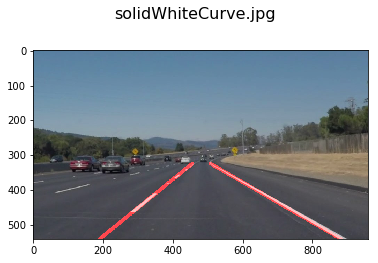

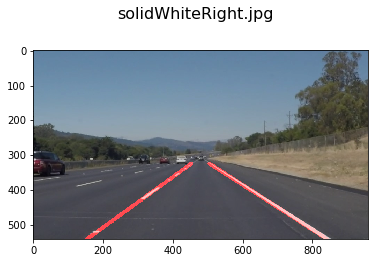

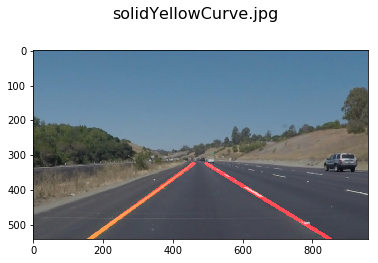

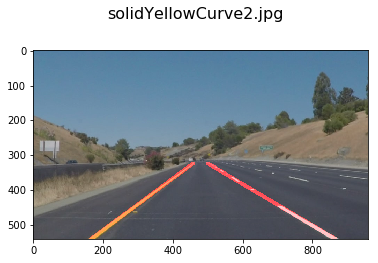

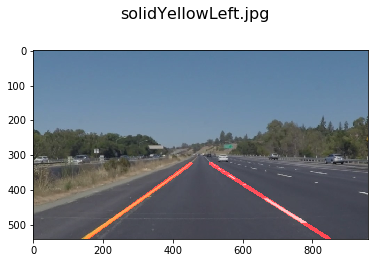

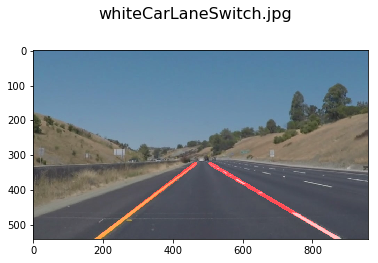

In [547]:
process('test_images/')

In [528]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [529]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)
    return result

In [558]:
white_output = 'results/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


MoviePy: building video file results/solidWhiteRight.mp4
----------------------------------------

Writing video into results/solidWhiteRight.mp4
|----------| 0/213   0% [elapsed: 00:00 left: ?, ? iters/sec]

/usr/local/anaconda3/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))


Done writing video in results/solidWhiteRight.mp4 !                    
Your video is ready !
CPU times: user 2.18 s, sys: 590 ms, total: 2.77 s
Wall time: 2.74 s


In [559]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [560]:
yellow_output = 'results/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


MoviePy: building video file results/solidYellowLeft.mp4
----------------------------------------

Writing video into results/solidYellowLeft.mp4
|----------| 0/654   0% [elapsed: 00:00 left: ?, ? iters/sec]

/usr/local/anaconda3/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))


Done writing video in results/solidYellowLeft.mp4 !                    
Your video is ready !
CPU times: user 7.03 s, sys: 1.65 s, total: 8.68 s
Wall time: 7.98 s


In [561]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [562]:
challenge_output = 'results/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/challenge.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(challenge_output, audio=False)


MoviePy: building video file results/challenge.mp4
----------------------------------------

Writing video into results/challenge.mp4
|----------| 0/243   0% [elapsed: 00:00 left: ?, ? iters/sec]

/usr/local/anaconda3/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))


|###-------| 95/243  39% [elapsed: 00:01 left: 00:01, 94.81 iters/sec] 

/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: divide by zero encountered in int_scalars


|########--| 209/243  86% [elapsed: 00:02 left: 00:00, 83.19 iters/sec]Warning: in file test_videos/challenge.mp4, 1244160 bytes wanted but 0 bytes read,at frame 251/253, at time 10.04/10.11 sec. Using the last valid frame instead.
Done writing video in results/challenge.mp4 !                          
Your video is ready !
CPU times: user 2.71 s, sys: 680 ms, total: 3.39 s
Wall time: 3.18 s


In [563]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))